In [1]:
# starting with dataset generation
import torch
import random
import numpy as np
import cv2
from torch.utils.data import Dataset

# just a function to draw rectangles
def draw_rectangle(image, top_left, width, height, color):
    x, y = top_left
    cv2.rectangle(
        image,
        (x, y),
        (x + width, y + height),
        color,
        thickness=-1
    )

In [2]:
def generate_sample(H=128, W=128, max_objects=4):

    # Create blank image
    image = np.zeros((H, W, 3), dtype=np.uint8)

    # Create label maps
    pos_map = np.zeros((H, W), dtype=np.float32)
    width_map = np.zeros((H, W), dtype=np.float32)
    height_map = np.zeros((H, W), dtype=np.float32)

    num_objects = random.randint(1, max_objects)

    for _ in range(num_objects):

        obj_w = random.randint(10, 40)
        obj_h = random.randint(10, 40)

        x = random.randint(0, W - obj_w - 1)
        y = random.randint(0, H - obj_h - 1)

        # Random color rectangle
        color = (
            random.randint(50, 255),
            random.randint(50, 255),
            random.randint(50, 255)
        )

        draw_rectangle(image, (x, y), obj_w, obj_h, color)

        # Encode label
        pos_map[y, x] = 1
        width_map[y, x] = obj_w
        height_map[y, x] = obj_h

    # Convert to tensors
    image = torch.tensor(image).permute(2,0,1).float() / 255.0

    label = torch.stack([
        torch.tensor(pos_map),
        torch.tensor(width_map),
        torch.tensor(height_map)
    ])

    return image, label


In [3]:
class SyntheticBBoxDataset(Dataset):

    def __init__(self, num_samples=500, H=128, W=128):
        self.num_samples = num_samples
        self.H = H
        self.W = W

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return generate_sample(self.H, self.W)


In [4]:
#just some functions for debugging
import matplotlib.pyplot as plt

def show_all_images(dataset):

    for i in range(len(dataset)):
        image, _ = dataset[i]

        plt.imshow(image.permute(1,2,0))
        plt.title(f"Image {i}")
        plt.axis("off")
        plt.show()

def visualize_maps(image, label):

    pos_map = label[0]
    width_map = label[1]
    height_map = label[2]

    fig, axs = plt.subplots(1, 4, figsize=(16,4))

    # ---- Image ----
    axs[0].imshow(image.permute(1,2,0))
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    # ---- Position Map ----
    im1 = axs[1].imshow(pos_map, cmap='gray')
    axs[1].set_title("Position Map")
    axs[1].axis("off")
    plt.colorbar(im1, ax=axs[1])

    # ---- Width Map ----
    im2 = axs[2].imshow(width_map, cmap='viridis')
    axs[2].set_title("Width Map")
    axs[2].axis("off")
    plt.colorbar(im2, ax=axs[2])

    # ---- Height Map ----
    im3 = axs[3].imshow(height_map, cmap='viridis')
    axs[3].set_title("Height Map")
    axs[3].axis("off")
    plt.colorbar(im3, ax=axs[3])

    plt.show()

2
torch.Size([3, 128, 128]) torch.Size([3, 128, 128])


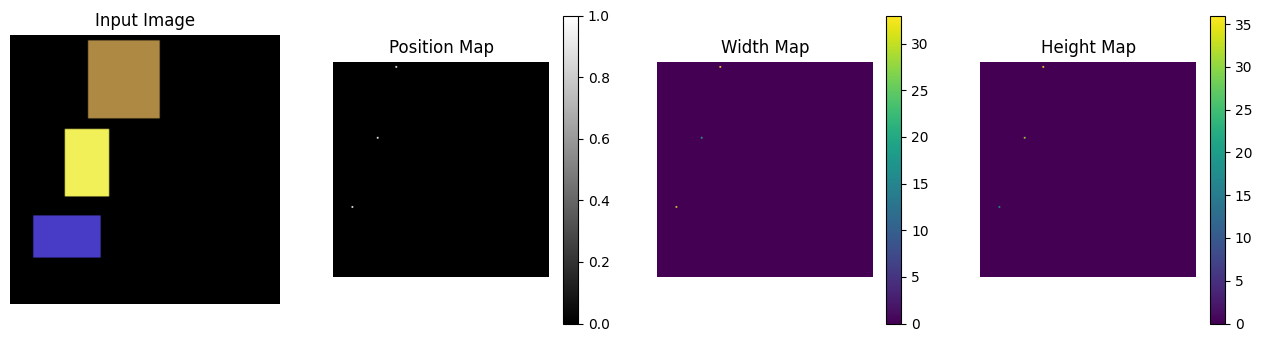

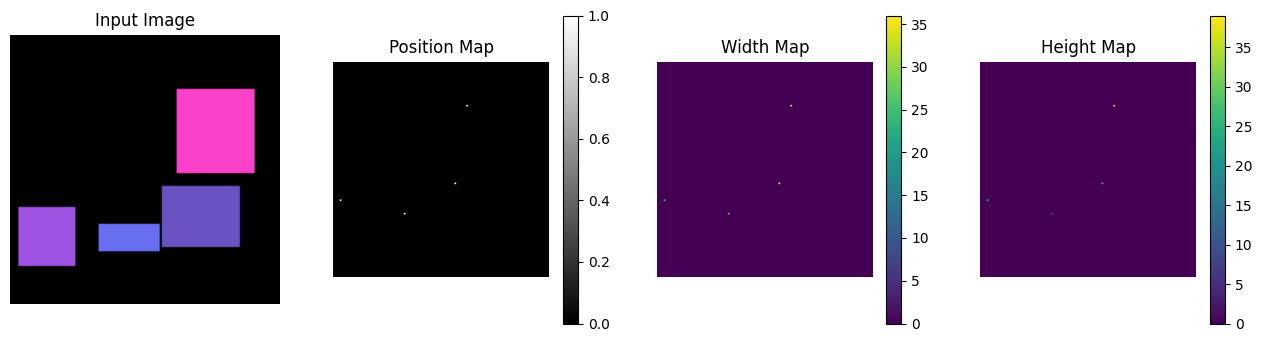

In [6]:
test_dataset = SyntheticBBoxDataset(num_samples=2)
print(len(test_dataset))
img, lbl = test_dataset[0]
img2 , lbl2 = test_dataset[1]
print(img.shape, lbl.shape)
# show_all_images(test_dataset)
visualize_maps(img, lbl)
visualize_maps(img2, lbl2)

In [7]:
import matplotlib.pyplot as plt

def visualize_sample(image, label):

    img = image.permute(1,2,0).numpy().copy()

    pos = label[0].numpy()
    w_map = label[1].numpy()
    h_map = label[2].numpy()

    H, W = pos.shape

    for y in range(H):
        for x in range(W):

            if pos[y,x] == 1:
                w = int(w_map[y,x])
                h = int(h_map[y,x])

                cv2.rectangle(
                    img,
                    (x,y),
                    (x+w, y+h),
                    (1,0,0),
                    2
                )

    plt.imshow(img)
    plt.title("Bounding Boxes")
    plt.axis("off")
    plt.show()


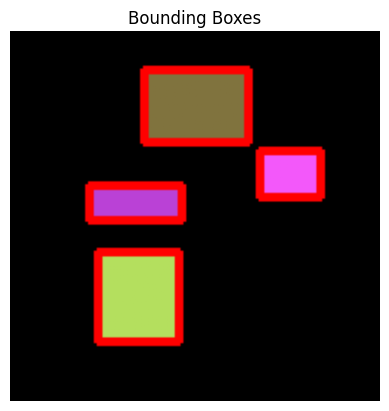

In [10]:
dataset = SyntheticBBoxDataset(num_samples=5)

img, lbl = dataset[0]
visualize_sample(img, lbl)


## issue :
currently only object in img is rectangle , need variations

In [11]:
# starting with model - cnn first
import torch
import torch.nn as nn
import torch.nn.functional as F

class BBoxCNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)

        self.head = nn.Conv2d(64, 3, 1)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        out = self.head(x)
        return out


In [12]:
def detection_loss(pred, target):

    pos_pred = pred[:,0]
    w_pred = pred[:,1]
    h_pred = pred[:,2]

    pos_target = target[:,0]
    w_target = target[:,1]
    h_target = target[:,2]

    # ---- Position loss ----
    bce = nn.BCEWithLogitsLoss()
    loss_pos = bce(pos_pred, pos_target)

    # ---- Mask ----
    mask = pos_target

    # ---- Width / Height regression ----
    loss_w = torch.mean(mask * (w_pred - w_target)**2)
    loss_h = torch.mean(mask * (h_pred - h_target)**2)

    return loss_pos + loss_w + loss_h


In [13]:
from torch.utils.data import DataLoader

dataset = SyntheticBBoxDataset(num_samples=500)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

model = BBoxCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(15):

    total_loss = 0

    for images, labels in loader:

        preds = model(images)

        loss = detection_loss(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print("Epoch:", epoch, "Loss:", total_loss)



Epoch: 0 Loss: 12.730496877804399
Epoch: 1 Loss: 2.1869475599378347
Epoch: 2 Loss: 1.9011764265596867
Epoch: 3 Loss: 1.8782750722020864
Epoch: 4 Loss: 1.794731017202139
Epoch: 5 Loss: 1.8084117714315653
Epoch: 6 Loss: 1.7252194378525019
Epoch: 7 Loss: 1.6922574527561665
Epoch: 8 Loss: 1.681406857445836
Epoch: 9 Loss: 1.6934814834967256
Epoch: 10 Loss: 1.689835793338716
Epoch: 11 Loss: 1.683002969250083
Epoch: 12 Loss: 1.6149348970502615
Epoch: 13 Loss: 1.6599486004561186
Epoch: 14 Loss: 1.5967067051678896


In [14]:
model.eval()

BBoxCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (head): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [15]:
def decode_predictions(pred, threshold=0.5):

    pred = pred.detach()

    pos_map = torch.sigmoid(pred[0])
    w_map = pred[1]
    h_map = pred[2]

    boxes = []

    H, W = pos_map.shape

    for y in range(H):
        for x in range(W):

            if pos_map[y,x] > threshold:

                w = w_map[y,x].item()
                h = h_map[y,x].item()

                if w > 0 and h > 0:
                    boxes.append([x, y, x+w, y+h])

    return boxes


In [16]:
def decode_ground_truth(label):

    pos = label[0]
    w_map = label[1]
    h_map = label[2]

    boxes = []

    ys, xs = torch.nonzero(pos, as_tuple=True)

    for y, x in zip(ys, xs):

        w = w_map[y,x].item()
        h = h_map[y,x].item()

        boxes.append([x, y, x+w, y+h])

    return boxes


In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(image, pred_boxes, gt_boxes):

    img = image.permute(1,2,0).numpy().copy()

    # Draw ground truth (Green)
    for box in gt_boxes:
        x1,y1,x2,y2 = map(int, box)
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,1,0), 2)

    # Draw predictions (Red)
    for box in pred_boxes:
        x1,y1,x2,y2 = map(int, box)
        cv2.rectangle(img, (x1,y1), (x2,y2), (1,0,0), 2)

    plt.imshow(img)
    plt.title("Green = GT | Red = Prediction")
    plt.axis("off")
    plt.show()


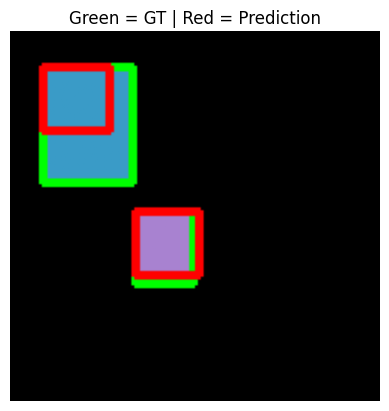

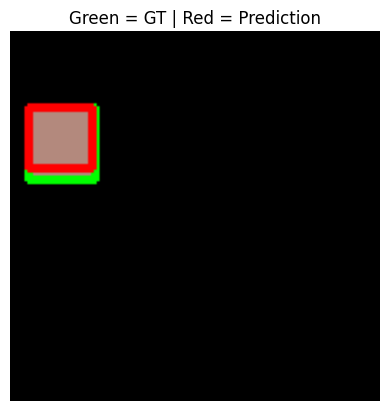

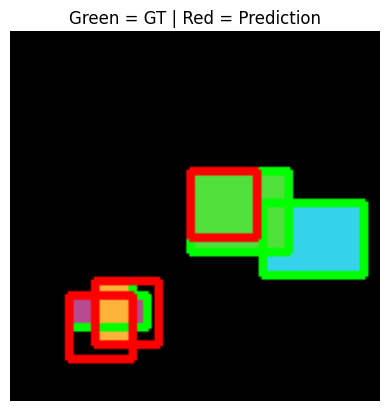

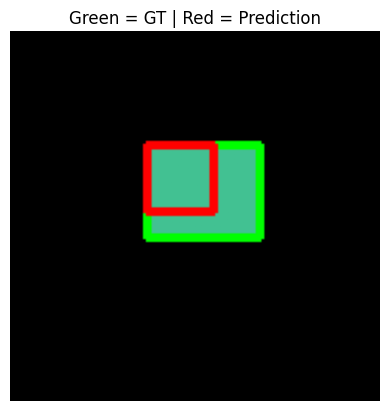

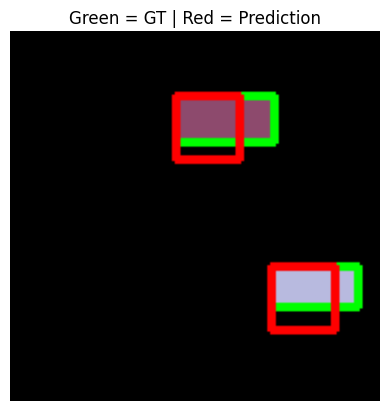

In [23]:
model.eval()

for i in range(5):

    image, label = dataset[i]

    with torch.no_grad():
        pred = model(image.unsqueeze(0))[0]

    pred_boxes = decode_predictions(pred)
    gt_boxes = decode_ground_truth(label)

    visualize_predictions(image, pred_boxes, gt_boxes)

